In [184]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

In [185]:
df = pd.read_csv('./fires_in_ph_clean_2.0.csv')

There are some public housing buildings that share an address, even though they are separate structures. For this analysis, in that case, I will keep only the first record. However, future work should be done to see if improved matching is possible.

In [186]:
building_fire_cols = ['building_fires_' + str(x) for x in range(2012, 2022)]

df['total_fires'] = df[building_fire_cols].sum(axis=1)

## Do some buildings stand out as being the worst?

In [187]:
df['fires_adj'] = df.total_fires / df.total_units

Most buildings don't have any fires from 2011-2021.

In [188]:
len(df[df.total_fires == 0]) / len(df)

0.9742754010377705

But those that do usually have more than one fire in that time period.

In [189]:
df[df['total_fires'] > 0]['total_fires'].mean()

4.083775675051927

We can also look at fires per unit

In [190]:
df[df['fires_adj'] > 0]['fires_adj'].mean()

0.44664700280633257

88 buildings in our dataset have had, on average, at least one fire a year for the last 10 years.

In [191]:
len(df[df.total_fires > 10])

271

These buildings have had about 1.6 fires per unit. 

In [192]:
df[df.total_fires > 10].fires_adj.mean()

0.5154730385348105

These buildings are mostly elevator-structure buildings.

In [193]:
building_type_cols = [x for x in df.columns if 'building_type_code_' in x]
df[(df.total_fires > 10)][building_type_cols].sum()

building_type_code_ES     133.059524
building_type_code_NDS      0.000000
building_type_code_RW      62.206091
building_type_code_SD      26.712308
building_type_code_SF       4.370724
building_type_code_WU      44.651353
dtype: float64

In [194]:
print(df[df.total_fires > 0].total_units.describe())
print()
print(df[df.total_fires == 0].total_units.describe())

count    4333.000000
mean       32.569351
std        54.754451
min         1.000000
25%         2.000000
50%         4.000000
75%        47.000000
max       502.000000
Name: total_units, dtype: float64

count    164105.000000
mean          5.093714
std          16.335890
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1826.000000
Name: total_units, dtype: float64


[Link with info](https://www.hud.gov/sites/documents/DOC_11633.PDF) on building code abbreviations.

* SF -> Single Family / Detached
* RW -> Row/Townhouse Dwelling
* WU -> Walk-UP/MultiFamily Apartment
* ES -> Elevator Structure 
* SD -> Semi-Detatched

In [195]:
(df.groupby('building_type_code').size() / len(df)).sort_values(ascending=False)

building_type_code
SD                                                                                                                                                                                                      0.368984
RW                                                                                                                                                                                                      0.298775
SF                                                                                                                                                                                                      0.213675
WU                                                                                                                                                                                                      0.079632
ES                                                                                                                                               

In [196]:
df.groupby('building_type_code').total_fires.mean().sort_values(ascending=False)

building_type_code
WUWURWRWRWRWWUWURWRWRWRWRWRWRWWURWRWWU                                                                                                                                                                  342.0
RWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRW                                                                                                                    336.0
RWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRW                                                                                                                                180.0
SDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSD                                                                                                      147.0
ESRWRWRW                                                                                                                                                     

In [197]:
df.groupby('building_type_code').fires_adj.mean().sort_values(ascending=False)

building_type_code
SDSDRWRWSDSDSDRWSDSDSD                                                                                                                                                                                  4.074074
WUWURWRWRWRWWUWURWRWRWRWRWRWRWWURWRWWU                                                                                                                                                                  2.098160
SFSDSDRWSFRWSFSFSFSFSFRWSFRWRW                                                                                                                                                                          1.875000
SDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSDSD                                                                                                      1.500000
RWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRWRW                                                             

S is house/street and H is highrise

In [198]:
df.groupby('addr_type').size().sort_values(ascending=False) / len(df)

KeyError: 'addr_type'

In [ ]:
df.groupby('addr_type').total_fires.mean().sort_values(ascending=False)

addr_type
F    3.000000
H    0.193199
S    0.018992
G    0.000000
P    0.000000
R    0.000000
Name: total_fires, dtype: float64

In [ ]:
df.groupby('addr_type').fires_adj.mean().sort_values(ascending=False)

addr_type
F    0.035294
S    0.010909
H    0.008969
G    0.000000
P    0.000000
R    0.000000
Name: fires_adj, dtype: float64

In [ ]:
df.total_fires.sum()

10728

##### !!!!!!!!!! Even though a building being large is a good predictor that it will have at least one fire, most large buildings have zero matched fires! So identifying high risk properties within ES structures might be helpful. However, we might need to grade the classifier differntly. For example, it might be great at identifying all ES properties as high risk, but then doing nothing else to diferentiate them.

In [ ]:
print(df[df.building_type_code == 'ES'].total_fires.sum(),
df[df.building_type_code != 'ES'].total_fires.sum()
)

6520 4208


In [ ]:
print(df[df.addr_type == 'H'].total_fires.sum(),
df[df.addr_type != 'H'].total_fires.sum())

8107 2621


In [ ]:
print(df[(df.addr_type == 'H') | (df.building_type_code == 'ES')].total_fires.sum(),
df[(df.addr_type != 'H') & (df.building_type_code != 'ES')].total_fires.sum())

8184 2544


In [ ]:
large_only = df[(df.addr_type == 'H') | (df.building_type_code == 'ES')]
len(large_only[large_only.total_fires > 0]) / len(df)

0.010240508637986295

## Do buildings with fires differ in terms of year-built?

In [ ]:
df['construction_year'] = pd.to_datetime(df['construct_date']).dt.year
df['construction_month'] = pd.to_datetime(df['construct_date']).dt.month_name()
df.loc[df['construction_year'] > 2023, 'construction_year'] = np.nan

In [ ]:
df[df.total_fires == 0].construction_year.describe()

count    148354.000000
mean       1972.328727
std          17.502779
min        1791.000000
25%        1962.000000
50%        1971.000000
75%        1982.000000
max        2022.000000
Name: construction_year, dtype: float64

In [ ]:
df[df.total_fires > 0].construction_year.describe()

count    3186.000000
mean     1974.064030
std        18.919037
min      1900.000000
25%      1964.000000
50%      1971.000000
75%      1983.000000
max      2022.000000
Name: construction_year, dtype: float64

In [ ]:
df[df.construction_year >= 1992].total_fires.mean()

0.04992833253702819

In [ ]:
df[df.construction_year < 1992].total_fires.mean()

0.055455171885766784

## Base rates of different states

Fires per public housing building.

In [ ]:
(
df.groupby('std_st').total_fires.sum() / df.groupby('std_st').size()
 ).sort_values(ascending=False)

std_st
MA    0.497135
NJ    0.484922
DC    0.221893
RI    0.221698
CT    0.148994
PA    0.144901
ME    0.141071
NH    0.113636
IL    0.100409
NE    0.094624
WA    0.094064
MI    0.088818
NY    0.085098
SD    0.078804
MD    0.073046
MN    0.067164
KY    0.064237
DE    0.053016
OH    0.050578
NV    0.050201
ID    0.049645
VA    0.047840
UT    0.044983
SC    0.043406
CO    0.041806
AK    0.040000
WV    0.032228
WI    0.031126
ND    0.027322
GA    0.026974
IN    0.026750
TN    0.026459
KS    0.026087
IA    0.024661
NC    0.021669
MO    0.019772
WY    0.018939
OK    0.018694
HI    0.018229
AZ    0.018018
CA    0.017996
FL    0.015157
MS    0.014003
OR    0.012647
LA    0.011330
TX    0.009909
MT    0.007653
AL    0.007151
AR    0.006211
NM    0.002764
GU    0.000000
VI    0.000000
VT    0.000000
PR    0.000000
dtype: float64

In [ ]:
(
df.groupby('std_st').fires_adj.mean()
 ).sort_values(ascending=False)

std_st
CT    0.037196
MA    0.023967
MD    0.023117
ID    0.021630
PA    0.020529
SD    0.019805
NJ    0.019328
MN    0.016564
RI    0.016322
NE    0.016164
SC    0.015897
MI    0.015604
DE    0.015549
OH    0.015068
IL    0.013748
WI    0.013497
DC    0.012465
NV    0.012110
UT    0.011667
CO    0.010896
GA    0.010624
TN    0.010333
NH    0.010301
KY    0.010099
WA    0.010009
AZ    0.009912
KS    0.009900
NC    0.009536
ME    0.009483
ND    0.008726
MO    0.008224
OR    0.007918
IN    0.007813
IA    0.007420
VA    0.006996
FL    0.006630
NY    0.006614
OK    0.006217
MS    0.006180
LA    0.005763
WV    0.005731
AK    0.005403
CA    0.004531
AL    0.003332
AR    0.003067
TX    0.003061
MT    0.002551
NM    0.002533
WY    0.002112
HI    0.001841
PR    0.000000
VI    0.000000
VT    0.000000
GU    0.000000
Name: fires_adj, dtype: float64

## Fires in elevator structures / highrises

In [ ]:
oth_death_cols = ['oth_death_' + str(x) for x in range(2012, 2022)]
df['total_deaths'] = df[oth_death_cols].sum(axis=1)

oth_inj_cols = ['oth_inj_' + str(x) for x in range(2012, 2022)]
df['total_inj'] = df[oth_inj_cols].sum(axis=1)

prop_loss_cols = ['prop_loss_' + str(x) for x in range(2012, 2022)]
df['total_prop_loss'] = df[prop_loss_cols].sum(axis=1)

cont_loss_cols = ['cont_loss_' + str(x) for x in range(2012, 2022)]
df['total_cont_loss'] = df[cont_loss_cols].sum(axis=1)

In [ ]:
highrise = df[
    (df.addr_type == 'H') |
    (df.building_type_code == 'ES')
]

About 60% of public housing units are in highrise buildings.

In [ ]:
highrise.total_units.sum() / df.total_units.sum()

0.597231192177903

But only 20% of buildings are highrises

In [ ]:
len(highrise) / len(df)

0.2197097219688876

75% of fires occur in highrise buildings.

In [ ]:
highrise.total_fires.sum() / df.total_fires.sum()

0.7628635346756152

80% of property value lost occurs in high rises.

In [ ]:
highrise.total_prop_loss.sum() / df.total_prop_loss.sum()

0.8014288868443892

Even more so for "container loss" (contents of buildings destroyed by fires)

In [ ]:
highrise.total_cont_loss.sum() / df.total_cont_loss.sum()

0.8529888774815689

62% of injuries occurred in highrises.

In [ ]:
print(df.total_inj.sum())
highrise.total_inj.sum() / df.total_inj.sum()

184


0.6195652173913043

Fewer than half of deaths were in highrises.

In [ ]:
print(df.total_deaths.sum())
highrise.total_deaths.sum() / df.total_deaths.sum()

8


0.375

Text(0.5, 1.0, 'Coorelations for Number of Building Fires in Public Housing Buildings')

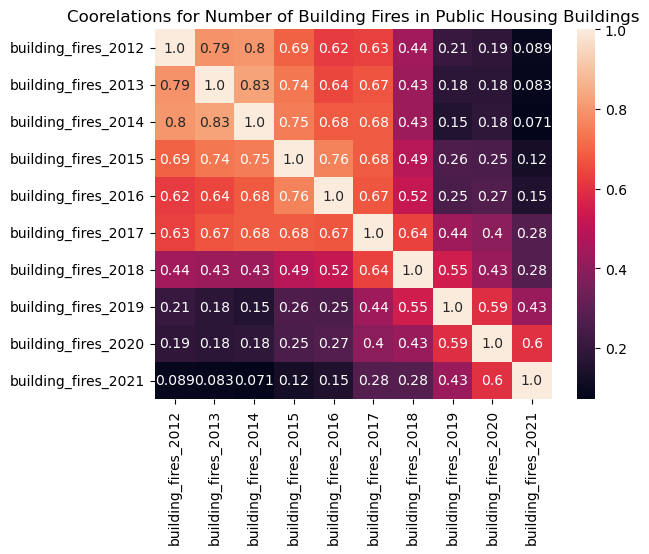

In [ ]:
building_fire_cols = ['building_fires_' + str(x) for x in range(2012, 2022)]
sns.heatmap(df[building_fire_cols].corr(), annot=True, fmt='.2')
plt.title('Coorelations for Number of Building Fires in Public Housing Buildings')

In [ ]:
highrise.sort_values('total_fires', ascending=False)

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email,building_fires_2012,prop_loss_2012,cont_loss_2012,oth_death_2012,oth_inj_2012,building_fires_2013,prop_loss_2013,cont_loss_2013,oth_death_2013,oth_inj_2013,building_fires_2014,prop_loss_2014,cont_loss_2014,oth_death_2014,oth_inj_2014,building_fires_2015,prop_loss_2015,cont_loss_2015,oth_death_2015,oth_inj_2015,building_fires_2016,prop_loss_2016,cont_loss_2016,oth_death_2016,oth_inj_2016,building_fires_2017,prop_loss_2017,cont_loss_2017,oth_death_2017,oth_inj_2017,building_fires_2018,prop_loss_2018,cont_loss_2018,oth_death_2018,oth_inj_2018,building_fires_2019,prop_loss_2019,cont_loss_2019,oth_death_2019,oth_inj_2019,building_fires_2020,prop_loss_2020,cont_loss_2020,oth_death_2020,oth_inj_2020,building_fires_2021,prop_loss_2021,cont_loss_2021,oth_death_2021,oth_inj_2021,total_fires,fires_adj,construction_year,construction_month,total_deaths,total_inj,total_prop_loss,total_cont_loss
4334,-74.783478,40.228398,5263,NJ005,Trenton Housing Authority,NJ005000004,JOSEPHSON APTS,French Towers,CF01,ES,INAPCP,2.270610e+09,1970/03/30 00:00:00+00,1971/03/30 00:00:00+00,150,150,135,15,151,89.400002,134,99.260002,7.0,14.93,1.0,139.0,319.0,1043.0,935.0,13552.0,13064.0,1.50,9.770000,66.169998,11.28,11.28,5.97,0.00,93.279999,11.750000,98.510002,94.029999,0.0,0.0,47.009998,0.0,82.139999,58.970001,66.190002,0.0,5.22,36.570000,58.209999,2.240000,91.040001,77.610001,0.00,0.000000,13.430000,49.0,95.0,0.0,0.0,100.000000,0.00,0.0,0.0,96.660004,47.209999,5.070000,0.0,56.830002,33.810001,100.000000,10704.0,34.0,Mercer,21.0,1102.0,3.0,3015.0,NaN,NaN,Mercer,21.0,74000.0,Trenton,74000.0,Trenton city,C5,NaN,8480.0,"Trenton, NJ PMSA",45940.0,"Trenton-Princeton, NJ Metropolitan Statistical...",99999.0,NaN,1.0,0.0,3412,3216.0,NaN,NaN,630 W STATE ST,NaN,TRENTON,NJ,8618.0,5572.0,NaN,8618.0,99.0,0.0,8.618557e+09,H,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,40.228398,-74.783478,S,NaN,R,U,** Street-Level Rooftop **,34021.0,3474000.0,3.402100e+10,3.402100e+11,N,,2023/03/06 08:50:52+00,1689785.0,1560029.0,1495,NJ005000004CF01630,6092785042,6.096000e+09,NaN,6.092785e+09,6.093942e+09,jgarrett@tha-nj.org,58,0,0,0,0,56,0,0,0,0,71,0,0,0,0,45,0,0,0,0,37,0,0,0,0,43,0,0,0,0,17,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,3

## Check the damages from the identified fires

In [ ]:
conn = sqlite3.Connection('./data/nfirs/fire_data.db')
test = pd.read_sql("""
    select 
        COALESCE(NUM_MILE, '') || ' ' || COALESCE(STREET_PRE, '') || ' ' || COALESCE(STREETNAME, '') || ' ' || COALESCE(STREETTYPE, '') || ' ' || COALESCE(STREETSUF, '') as FULL_ADDRESS,
        APT_NO,
        CITY,
        STATE_ID,
        ZIP5,
        INCIDENT_KEY
    from incident_address
    where LOC_TYPE = 1
        and APT_NO NOT NULL
    limit 10
""", conn)
test

,FULL_ADDRESS,APT_NO,CITY,STATE_ID,ZIP5,INCIDENT_KEY
0,4000 EGAN DR,BLOCK,JUNEAU,AK,99801,AK_11100_02172021_21639_0
1,401 EGAN DR,BLOCK,JUNEAU,AK,99801,AK_11100_02182021_21650_0
2,1968 LEMON CREEK RD,2,JUNEAU,AK,99801,AK_11100_03022021_21813_0
3,5905 CHURCHILL WAY,61,JUNEAU,AK,99801,AK_11100_03112021_21935_0
4,4449 EYELET CT,BLOCK,JUNEAU,AK,99801,AK_11100_03192021_211027_0
5,5905 CHURCHILL WAY,61,JUNEAU,AK,99801,AK_11100_04042021_211229_0
6,1800 CREST ST,Suite 112,JUNEAU,AK,99801,AK_11100_04152021_211393_0
7,6590 GLACIER HWY,66,JUNEAU,AK,99801,AK_11100_04292021_211557_0
8,3220 HOSPITAL DR,101,JUNEAU,AK,99801,AK_11100_04292021_211560_0
9,800 F ST,P5,JUNEAU,AK,99801,AK_11100_04302021_211578_0


In [ ]:
df.sample()

,x,y,objectid,participant_code,formal_participant_name,development_code,project_name,building_name,building_number,building_type_code,building_status_type_code,national_bldg_id,construct_date,dofa_actual_dt,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,pct_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_female_head_child,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_native_american,pct_asian,pct_hispanic,months_waiting,months_from_movein,pct_utility_allow,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,state2kx,cnty_nm2kx,cnty2kx,tract2kx,bg2kx,block2kx,dpvact,dpvnost,curcnty_nm,curcnty,curcosub,curcosub_nm,place2kx,place_nm2kx,place_cc2kx,place_inc2kx,msa,msa_nm,cbsa,cbsa_nm,necta,necta_nm,metro,micro,fcd_fips91,hlc,dpv,dpvrc,std_addr,urb_out,std_city,std_st,std_zip5,std_zip9,zip_class,zcta2kx,dpbc,dpbc_cksum,std_zip11,addr_type,apt_no,apt_type,c1pgrc,c1pprb,c1pdrc,c1psrc,c1parc,c1pzrc,msgusps,lat,lon,rc2kx,stm2kx,lvl2kx,ur,msg2kx,county_level,place_level,tract_level,blkgrp_level,rad_chap_indr,rad_type,last_updt_dttm,annl_expns_amnt,annl_expns_amnt_prev_yr,pha_total_units,dev_buil_nu_entrance,ha_phn_num,ha_fax_num,ha_email_addr_text,exec_dir_phone,exec_dir_fax,exec_dir_email,building_fires_2012,prop_loss_2012,cont_loss_2012,oth_death_2012,oth_inj_2012,building_fires_2013,prop_loss_2013,cont_loss_2013,oth_death_2013,oth_inj_2013,building_fires_2014,prop_loss_2014,cont_loss_2014,oth_death_2014,oth_inj_2014,building_fires_2015,prop_loss_2015,cont_loss_2015,oth_death_2015,oth_inj_2015,building_fires_2016,prop_loss_2016,cont_loss_2016,oth_death_2016,oth_inj_2016,building_fires_2017,prop_loss_2017,cont_loss_2017,oth_death_2017,oth_inj_2017,building_fires_2018,prop_loss_2018,cont_loss_2018,oth_death_2018,oth_inj_2018,building_fires_2019,prop_loss_2019,cont_loss_2019,oth_death_2019,oth_inj_2019,building_fires_2020,prop_loss_2020,cont_loss_2020,oth_death_2020,oth_inj_2020,building_fires_2021,prop_loss_2021,cont_loss_2021,oth_death_2021,oth_inj_2021,total_fires,fires_adj,construction_year,construction_month,total_deaths,total_inj,total_prop_loss,total_cont_loss
79155,-93.074116,31.740992,157183,LA115,Housing Authority of the City of Natchitoches,LA115000010,East Natchitoches,NaN,000209,SD,INAPCP,5.321110e+09,1990/05/15 00:00:00+00,1990/05/31 00:00:00+00,2,2,2,0,2,100.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,Natchitoches,69.0,600.0,3.0,3011.0,NaN,NaN,Natchitoches,69.0,94852.0,District 5,53545.0,Natchitoches city (part),C1,NaN,9999.0,NaN,35060.0,"Natchitoches, LA Micropolitan Statistical Area",99999.0,NaN,0.0,1.0,2204,1272.0,NaN,NaN,613 JACKSON DR,NaN,NATCHITOCHES,LA,71457.0,5461.0,NaN,71457.0,13.0,6.0,7.145755e+10,S,NaN,NaN,NaN,1.0,NaN,NaN,A,NaN,90% Overall probable correctness,31.740992,-93.074116,S,NaN,R,U,** Street-Level Rooftop **,22069.0,2253545.0,2.206900e+10,2.206900e+11,N,,2023/03/06 08:50:52+00,NaN,NaN,398,LA115000010000209001,3183529774,3.183578e+09,mllorence@cp-tel.net,3.183530e+09,3.183578e+09,mllorence@cp-tel.net,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,1990.0,May,0,0,0,0


## Manual inspection sanity check

For the worst properties, and UT, and some random properties, manually check the NFIRS database and the public housing dataset.

## Look at all highrise buildings where a fire was identified, and then pull the full info from FEMA

## Summarize death, injury, and property loss, and how buildings with lots of that differ